In [1]:
import os

import numpy as np
import pandas as pd
import scipy as sp
import astropy as ap
import matplotlib.pyplot as plt

import scipy.stats
import scipy.optimize
import scipy.spatial
import scipy.cluster

import astropy.time
import astropy.units as u
import astropy.constants as c

# import emcee
# import corner

import sklearn
import sklearn.preprocessing
import sklearn.manifold
import sklearn.cluster
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn.metrics import confusion_matrix

# For running on Colaboratory
# ! pip install corner
# ! pip install emcee

# custom_mplstyle = ("https://raw.githubusercontent.com/FoxFortino"
#                    "/DSPS_WFortino/main/custom.mplstyle")
# plt.style.use(custom_mplstyle)

rng = np.random.RandomState(193)
n_estimators_test = 100
n_estimators = 100

In [175]:
# envs = json.load(open("/content/drive/MyDrive/.kaggle/kaggle.json", "r"))
# os.environ["KAGGLE_USERNAME"] = envs['username']
# os.environ["KAGGLE_KEY"] = envs['key']

In [175]:
# !mkdir -p /content/drive/MyDrive/Higgs

In [175]:
# !cd /content/drive/MyDrive/Higgs

In [175]:
# !kaggle competitions download -c higgs-boson

In [175]:
!ls /content/drive/MyDrive/Higgs

# Cleaning and Preprocessing

1. Remove EventID column. Keep it around but not in the models. Need to separate it out with train_test_learn too
2. Deal with the -999 values
3. Handle DER and PRI columns differently?
4. Handle PRI_jet_num being an integer
5. Whitening?`

In [2]:
kaggle_dir = "/Users/admin/Kaggle/higgs/higgs-boson"

trn_file = os.path.join(kaggle_dir, "training.zip")
tst_file = os.path.join(kaggle_dir, "test.zip")

trn_higgs = pd.read_csv(trn_file)
tst_higgs = pd.read_csv(tst_file)

trn_EventID = trn_higgs["EventId"]
tst_EventID = tst_higgs["EventId"]

trn_Label = trn_higgs["Label"]
trn_Weight = trn_higgs["Weight"]

trn_higgs.drop(columns=["EventId", "Label", "Weight"], inplace=True)
tst_higgs.drop(columns=["EventId"], inplace=True)

In [3]:
# Columns that have -999 entries in the training or test set
bad_cols = [                   # train / test
    "DER_mass_MMC",            # 38114 / 83822
    "DER_deltaeta_jet_jet",    # 177457 / 389872
    "DER_mass_jet_jet",        # 177457 / 389872
    "DER_prodeta_jet_jet",     # 177457 / 389872
    "DER_lep_eta_centrality",  # 177457 / 389872
    "PRI_jet_leading_pt",      # 99913 / 220156
    "PRI_jet_leading_eta",     # 99913 / 220156
    "PRI_jet_leading_phi",     # 99913 / 220156
    "PRI_jet_subleading_pt",   # 177457 / 389872
    "PRI_jet_subleading_eta",  # 177457 / 389872
    "PRI_jet_subleading_phi"   # 177457 / 389872
]

trn_ind = trn_higgs == -999
tst_ind = tst_higgs == -999

In [4]:
trn_higgs_cols = trn_higgs.columns
trn_scl_higgs = sklearn.preprocessing.scale(trn_higgs[~trn_ind])
trn_scl_higgs = pd.DataFrame(data=trn_scl_higgs, columns=trn_higgs_cols)
trn_scl_higgs[trn_ind] = -999

In [5]:
tst_higgs_cols = tst_higgs.columns
tst_scl_higgs = sklearn.preprocessing.scale(tst_higgs[~tst_ind])
tst_scl_higgs = pd.DataFrame(data=tst_scl_higgs, columns=tst_higgs_cols)
tst_scl_higgs[tst_ind] = -999

In [6]:
split = tts(
    trn_higgs,
    trn_scl_higgs,
    trn_EventID,
    trn_Label,
    trn_Weight,
    train_size=0.80,
    random_state=rng
)

unscl_Xtrain, unscl_Xvalid = split[0], split[1]
Xtrain, Xvalid = split[2], split[3]
EIDtrain, EID_valid = split[4], split[5]
Ltrain, Lvalid = split[6], split[7]
Wtrain, Wvalid = split[8], split[9]

In [7]:
max_depth_test = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]

In [8]:
for md in max_depth_test:
    rf =  RandomForestClassifier(
        n_estimators=n_estimators_test,
        criterion="gini",
        max_depth=md,
        random_state=rng
    )
    rf_fit = rf.fit(Xtrain, Ltrain)
    valid_score = rf.score(Xvalid, Lvalid)
    train_score = rf.score(Xtrain, Ltrain)
    print(f"Max Depth: {md}")
    print(f"    Train Score: {train_score:.3f}")
    print(f"    Valid Score: {valid_score:.3f}")
    print(f"    Difference Score: {train_score - valid_score:.5f}")

Max Depth: 1
    Train Score: 0.678
    Valid Score: 0.683
    Difference Score: -0.00502
Max Depth: 2
    Train Score: 0.748
    Valid Score: 0.749
    Difference Score: -0.00147
Max Depth: 3
    Train Score: 0.796
    Valid Score: 0.799
    Difference Score: -0.00309
Max Depth: 4
    Train Score: 0.809
    Valid Score: 0.812
    Difference Score: -0.00269
Max Depth: 5
    Train Score: 0.816
    Valid Score: 0.818
    Difference Score: -0.00272
Max Depth: 6
    Train Score: 0.822
    Valid Score: 0.824
    Difference Score: -0.00189
Max Depth: 7
    Train Score: 0.825
    Valid Score: 0.827
    Difference Score: -0.00188
Max Depth: 8
    Train Score: 0.830
    Valid Score: 0.830
    Difference Score: 0.00082
Max Depth: 9
    Train Score: 0.834
    Valid Score: 0.831
    Difference Score: 0.00387
Max Depth: 10
    Train Score: 0.841
    Valid Score: 0.834
    Difference Score: 0.00710
Max Depth: None
    Train Score: 1.000
    Valid Score: 0.840
    Difference Score: 0.16018


In [9]:
for md in max_depth_test:
    gbt =  GradientBoostingClassifier(
        n_estimators=n_estimators_test,
        max_depth=md,
        random_state=rng
    )
    gbt_fit = gbt.fit(Xtrain, Ltrain)
    valid_score = gbt_fit.score(Xvalid, Lvalid)
    train_score = gbt.score(Xtrain, Ltrain)
    print(f"Max Depth: {md}")
    print(f"    Train Score: {train_score:.3f}")
    print(f"    Valid Score: {valid_score:.3f}")
    print(f"    Difference Score: {train_score - valid_score:.5f}")

Max Depth: 1
    Train Score: 0.811
    Valid Score: 0.815
    Difference Score: -0.00336
Max Depth: 2
    Train Score: 0.822
    Valid Score: 0.823
    Difference Score: -0.00055
Max Depth: 3
    Train Score: 0.833
    Valid Score: 0.833
    Difference Score: -0.00035
Max Depth: 4
    Train Score: 0.839
    Valid Score: 0.838
    Difference Score: 0.00126
Max Depth: 5
    Train Score: 0.844
    Valid Score: 0.840
    Difference Score: 0.00442
Max Depth: 6
    Train Score: 0.850
    Valid Score: 0.843
    Difference Score: 0.00708


KeyboardInterrupt: 

# Random Forest Classifier Discussion

We choose a max depth of 8, noting that this is the greatest max depth where the model score is still greater than what it is for smaller max depth values, but the test score is less than 0.1% greater than the train score. This is an arbitrary decision I've made as a balance between model complexity and overfitting. I would have liked to have chosen a smaller max depth to save computational resources and time, but there seems to be no reason to choose something smaller since the score kept increasing.

# Gradient Boosting Classifier Discussion

We choose a max depth of 3 for this model because this is when the model accuracy plateaus and also when the test score becames more than 0.1% larger than the train score.

In [10]:
RFC_max_depth = 8
GBTC_max_depth = 3

In [11]:
rf =  RandomForestClassifier(
    n_estimators=n_estimators,
    criterion="gini",
    max_depth=RFC_max_depth,
    random_state=rng
)
rf_fit = rf.fit(Xtrain, Ltrain)
valid_score = rf.score(Xvalid, Lvalid)
train_score = rf.score(Xtrain, Ltrain)
print(f"Max Depth: {RFC_max_depth}")
print(f"    Train Score: {train_score:.3f}")
print(f"    Valid Score: {valid_score:.3f}")

Max Depth: 8
    Train Score: 0.830
    Valid Score: 0.829


In [12]:
gbt =  GradientBoostingClassifier(
    n_estimators=n_estimators,
    max_depth=GBTC_max_depth,
    random_state=rng
)
gbt_fit = gbt.fit(Xtrain, Ltrain)
valid_score = gbt.score(Xvalid, Lvalid)
train_score = gbt.score(Xtrain, Ltrain)
print(f"Max Depth: {GBTC_max_depth}")
print(f"    Train Score: {train_score:.3f}")
print(f"    Valid Score: {valid_score:.3f}")

Max Depth: 3
    Train Score: 0.833
    Valid Score: 0.833


In [16]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title='',
                          cmap=plt.cm.bone):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """         
    if normalize:
        title = title + ' Normalized Confusion Matrix'
        normalize = "all"
    else:
        title = title + ' Confusion Matrix'
        normalize = None

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)

    # plot it
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    fig.subplots_adjust()
    im = ax.imshow(cm, cmap=cmap, vmin=0, vmax=None)
    ax_divider = make_axes_locatable(ax)
    # add an axes to the right of the main axes.
    plt.xticks([0, 1], labels=["N", "P"])
    plt.ylim(-0.5,1.5)
    plt.yticks([0,1], labels=["N", "P"])    
    plt.title(title)
    cax = ax_divider.append_axes("right", size="10%", pad="2%")
    cb = plt.colorbar(im, cax=cax)
    

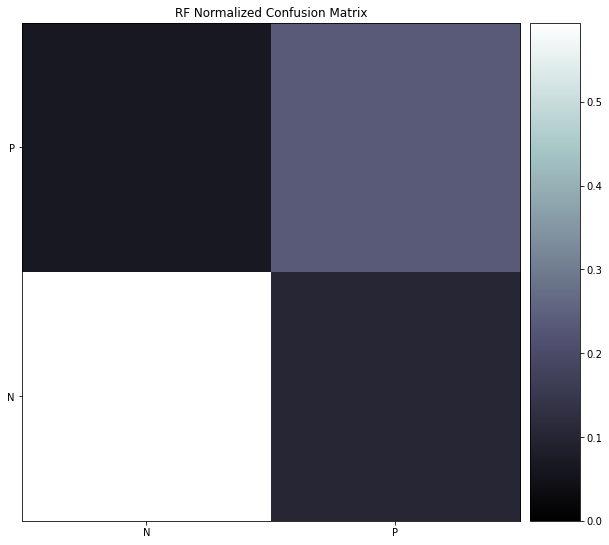

In [17]:
plot_confusion_matrix(rf.predict(Xvalid.values), Lvalid.values,
                      title="RF", normalize=True)

### Figure 1: Confusion matrix for the Random Forest classifier with a max depth of 4 and 100 estimators. We see that the model performs well at predicting true negatives, whereas prediciting true positives was more difficult for this model. Without domain knowledge, it is impossible to know whether this confusion matrix would be acceptable for the problem it is trying to solve.

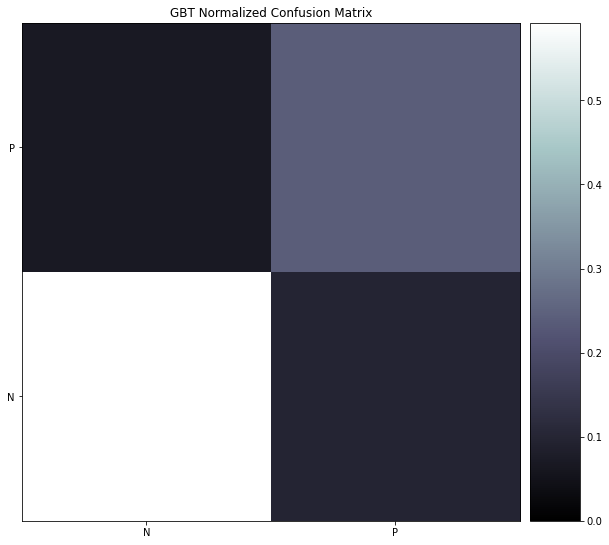

In [18]:
plot_confusion_matrix(gbt.predict(Xvalid.values), Lvalid.values,
                      title="GBT", normalize=True)

### Figure 2: Confusion matrix for the Gradient Boosting classifier with a max depth of 3 and 100 estimators. We see that the model performs well at predicting true negatives, whereas prediciting true positives was more difficult for this model. Without domain knowledge, it is impossible to know whether this confusion matrix would be acceptable for the problem it is trying to solve. This model performs similarly to the Random Forest Classifier shown in Figure 1.

In [22]:
for md in max_depth_test:
    rfr =  RandomForestRegressor(
        n_estimators=n_estimators_test,
        max_depth=md,
        random_state=rng
    )
    rfr_fit = rfr.fit(Xtrain, Wtrain)
    valid_score = rfr.score(Xvalid, Wvalid)
    train_score = rfr.score(Xtrain, Wtrain)
    print(f"Max Depth: {md}")
    print(f"    Train Score: {train_score:.3f}")
    print(f"    Valid Score: {valid_score:.3f}")
    print(f"    Difference Score: {train_score - valid_score:.5f}")

Max Depth: 1
    Train Score: 0.251
    Valid Score: 0.260
    Difference Score: -0.00819
Max Depth: 2
    Train Score: 0.415
    Valid Score: 0.424
    Difference Score: -0.00908
Max Depth: 3
    Train Score: 0.477
    Valid Score: 0.484
    Difference Score: -0.00698
Max Depth: 4
    Train Score: 0.518
    Valid Score: 0.526
    Difference Score: -0.00790
Max Depth: 5
    Train Score: 0.550
    Valid Score: 0.555
    Difference Score: -0.00495
Max Depth: 6
    Train Score: 0.579
    Valid Score: 0.582
    Difference Score: -0.00296
Max Depth: 7
    Train Score: 0.599
    Valid Score: 0.597
    Difference Score: 0.00134
Max Depth: 8
    Train Score: 0.617
    Valid Score: 0.609
    Difference Score: 0.00796
Max Depth: 9
    Train Score: 0.634
    Valid Score: 0.616
    Difference Score: 0.01836


KeyboardInterrupt: 

In [23]:
for md in max_depth_test:
    gbtr =  GradientBoostingRegressor(
        n_estimators=n_estimators_test,
        max_depth=md,
        random_state=rng
    )
    gbtr_fit = gbtr.fit(Xtrain, Wtrain)
    valid_score = gbtr.score(Xvalid, Wvalid)
    train_score = gbtr.score(Xtrain, Wtrain)
    print(f"Max Depth: {md}")
    print(f"    Train Score: {train_score:.3f}")
    print(f"    Valid Score: {valid_score:.3f}")
    print(f"    Difference Score: {train_score - valid_score:.5f}")

Max Depth: 1
    Train Score: 0.528
    Valid Score: 0.534
    Difference Score: -0.00609
Max Depth: 2
    Train Score: 0.595
    Valid Score: 0.600
    Difference Score: -0.00504
Max Depth: 3
    Train Score: 0.615
    Valid Score: 0.618
    Difference Score: -0.00252
Max Depth: 4
    Train Score: 0.628
    Valid Score: 0.626
    Difference Score: 0.00173
Max Depth: 5
    Train Score: 0.641
    Valid Score: 0.631
    Difference Score: 0.00939


KeyboardInterrupt: 

# Random Forest Regressor Discussion

We choose a max depth of 6 which is again a balance of model complexity and overfitting.

# Gradient Boosting Regressor Discussion

We choose a max depth of 3 for this model because this is when the model accuracy plateaus and also when the test score becames more than 0.1% larger than the train score.

In [24]:
RFR_max_depth = 6
GBTR_max_depth = 3

In [25]:
rfr =  RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=RFR_max_depth,
    random_state=rng
)
rfr_fit = rfr.fit(Xtrain, Wtrain)
valid_score = rfr.score(Xvalid, Wvalid)
train_score = rfr.score(Xtrain, Wtrain)
print(f"Max Depth: {RFR_max_depth}")
print(f"    Train Score: {train_score:.3f}")
print(f"    Valid Score: {valid_score:.3f}")

Max Depth: 6
    Train Score: 0.579
    Valid Score: 0.582


In [26]:
gbtr =  GradientBoostingRegressor(
    n_estimators=n_estimators,
    max_depth=GBTR_max_depth,
    random_state=rng
)
gbtr_fit = gbtr.fit(Xtrain, Wtrain)
valid_score = gbtr.score(Xvalid, Wvalid)
train_score = gbtr.score(Xtrain, Wtrain)
print(f"Max Depth: {GBTR_max_depth}")
print(f"    Train Score: {train_score:.3f}")
print(f"    Valid Score: {valid_score:.3f}")

Max Depth: 3
    Train Score: 0.615
    Valid Score: 0.618


In [27]:
def L(X, Y, model, p):
    return np.sum(np.power(np.abs(Y - model.predict(X)), p), axis=0)

In [29]:
print(f"L1 RF: {L(Xvalid, Wvalid, rfr, 1)}")
print(f"L2 RF: {L(Xvalid, Wvalid, rfr, 2)}")
print()
print(f"L1 GBT: {L(Xvalid, Wvalid, gbtr, 1)}")
print(f"L2 GBT: {L(Xvalid, Wvalid, gbtr, 2)}")

L1 RF: 44140.135463986524
L2 RF: 74085.44170143758

L1 GBT: 42144.52585274514
L2 GBT: 67714.96176818901


### L1 and L2 loss functions calculated for the random forest and gradient boosting regressors. The criteria for quality of each split for both models was "squared error" which likely corresponds to the L2 loss function. In both cases, the gradient boosting model performs better.

In [30]:
ind_sort = np.argsort(rf.feature_importances_)[::-1]
feats = Xtrain.columns[ind_sort]
feats_imp = rf.feature_importances_[ind_sort]
feats_imp_std = np.std([feats_imp for tree in rf.estimators_], axis=0)

N = 4
for f, fi, std in zip(feats[:N], feats_imp[:N], feats_imp_std[:N]):
    print(fi.round(3), ":", f)

0.269 : DER_mass_MMC
0.162 : DER_mass_transverse_met_lep
0.106 : DER_mass_vis
0.077 : PRI_tau_pt


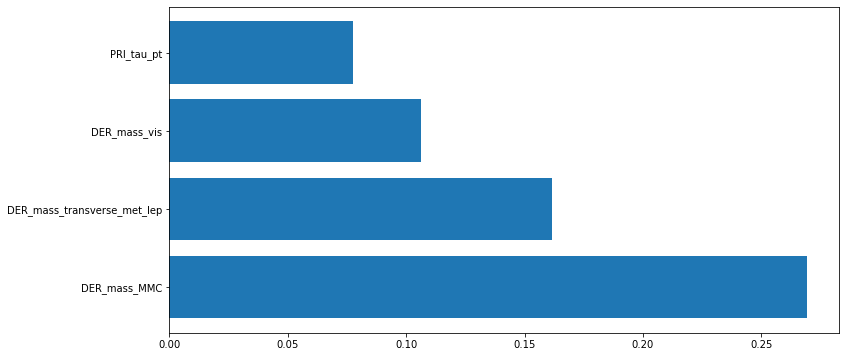

In [31]:
plt.figure(figsize=(12, 6))
plt.barh(range(N), feats_imp[:N], xerr=feats_imp_std[:N], align="center")
plt.yticks(range(N), labels=[str(feat) for feat in feats[:N]])
plt.show()

### Figure 3: Feature importance shown for the most important 4 out of 30 features in the dataset. According to the documentation, these features are:

1. DER_mass_MMC: the estimated mass of the Higgs boson candidate.
2. PRI_tau_pt: the transverse momentum of the hadronic tau.
3. DER_mass_transverse_met_lep: the transverse mass between the missing transverse energy and the lepton.
4. DER_pt_h: the modulus of the vector sum of the transverse momentum of the hadronic tau, the lepton, and the missing transverse energy vector.

In [39]:
random_submission = pd.read_csv(os.path.join(kaggle_dir, "random_submission.zip"))
sub = random_submission.copy()
sol = random_submission.copy()

In [40]:
Class = pd.Series(gbt.predict(tst_scl_higgs))
EventId = tst_EventID
RankOrder = pd.Series(Class.argsort().argsort() + 1)

sub["RankOrder"] = RankOrder
sub["Class"] = Class

sub.to_csv("submission.csv", index=False)

In [41]:
Weight = pd.Series(gbtr.predict(tst_scl_higgs))

sol["Class"] = Class
sol["Weight"] = Weight
sol.drop(columns="RankOrder", inplace=True)

sol.to_csv("solution.csv", index=False)

### Kaggle Validation
The output from the Kaggle validation file reads:
```
signal = 71075.6023224, background = 0.0
AMS = 1057.72067638
```
Uploading my submission to Kaggle gives me a public score (calculated with 18% of the test data) of 2.70445, and a private score (calculated with the remaining data) of 2.77731.

---

<h1 style="color:red"> Amazing !</h1>
